## Avaliação final - Aprendizado Dinâmico


Profa. **Cibele Russo**

**MBA em Ciências de Dados**

**Atenção: Você deve resolver as questões neste notebook e submetê-lo inteiramente executado no moodle.**

O arquivo de dados **covidSP_2021_2022.csv** contém dados da pandemia de COVID-19 no estado de São Paulo, de 02-01-2021 a 27-03-2022, de dados confirmados e mortes. Nessa avaliação, trabalharemos com os dados **confirmados** (confirmed).

1. Faça a leitura dos dados, estabeleça um índice por datas. Caso haja dados faltantes, complete os dados como indicado. Faça a visualização dos dados com gráfico de linhas e boxplots por semanas. Há evidências de estacionariedade nos gráficos? Por quê?


2. Proponha uma decomposição dos dados confirmados em tendência e sazonalidade. Comente as componentes de tendência, sazonalidade e resíduos. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Esses resultados indicam a presença de autocorrelação? Justifique.


3. Divida a série de registros confirmados em treinamento e teste, com 28 observações na base de teste. A que se referem os dados de treinamento e teste e como essa divisão contribui para a análise de modelos preditivos? 


4. Utilizando a base de treinamento de registros confirmados de COVID-19, obtenha:

    - As previsões de Holt Winters.
    
    - As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido (auto_arima), para a variável confirmed. Identifique a natureza das componentes desse melhor modelo (por exemplo, “o modelo componentes autorregressiva não sazonal, componente de médias móveis sazonal", etc).
    
    - As previsões com o método Theta usual.
    
    - As previsões com um modelo de redes neurais recorrentes (LSTM ou GRU).    
    
    

5. Utilize o erro absoluto médio para comparar as previsões obtidas com as observações da base de teste. Escolha o método que produz as melhores previsões. Justifique sua resposta. Represente em um mesmo gráfico a base de treinamento, de teste e as previsões obtidas pelos quatro métodos.


#### Boa prova!

## Item 1

1. Faça a leitura dos dados, estabeleça um índice por datas. Caso haja dados faltantes, complete os dados como indicado. Faça a visualização dos dados com gráfico de linhas e boxplots por semanas. Há evidências de estacionariedade nos gráficos? Por quê?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller


df = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/Aprendizado-Dinamico/main/Data/covidSP_2021_2022.csv', index_col=0, parse_dates=True)
df.head()

idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(idx)
df.fillna(method='ffill', inplace=True)
df = df.drop(columns=['deaths'])

# trazendo coluna de semana, baseado no padrão ISO 8601
df['week_number'] = pd.DatetimeIndex(df.index).isocalendar().week

# pelo padrão, as datas de 2021-01-02 e 2021-01-03 são 53. Transformando para 0 para iniciarem no gráfico
df = df.replace({'week_number':53}, 0)

# setando uma coluna de ano para diferenciar nos gráficos quando usar o nr da semana como data
df['year'] = pd.DatetimeIndex(df.index).year

In [2]:
df


,confirmed,week_number,year
2021-01-02,1762.0,0,2021
2021-01-03,3469.0,0,2021
2021-01-04,2248.0,1,2021
2021-01-05,12881.0,1,2021
2021-01-06,14534.0,1,2021
...,...,...,...
2022-03-23,9364.0,12,2022
2022-03-24,8953.0,12,2022
2022-03-25,9300.0,12,2022
2022-03-26,7177.0,12,2022


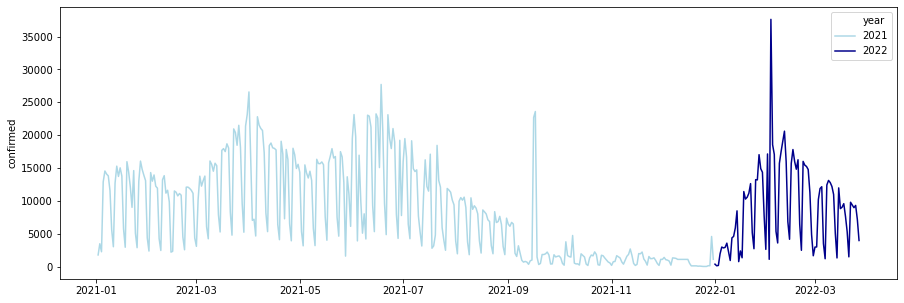

In [3]:
# gráfico de linha, usando index com data na frequência diária
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x= df.index, 
                y = df['confirmed'],
                hue = df['year'],
                palette = ['lightblue', 'darkblue'],
                ax = ax);

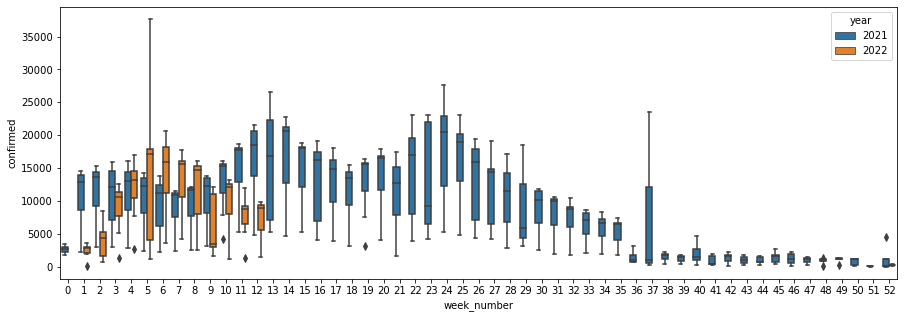

In [4]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x = df['week_number'], 
                y = df['confirmed'],
                hue = df['year'], 
                ax = ax);

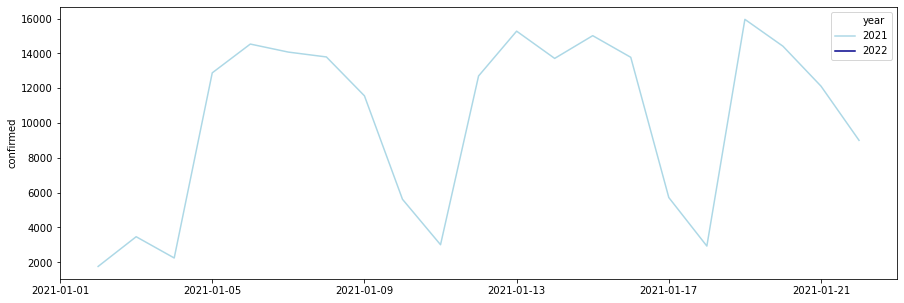

In [5]:
# pelos ciclos pico-vale, conseguimos enxergar uma sazonalidade
# dando um zoom nos dados, conseguimos ver que eles ciclos sazonais de 7 dias

# gráfico de linha, usando index com data na frequência diária
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x= df.index, 
                y = df['confirmed'][:21],
                hue = df['year'],
                palette = ['lightblue', 'darkblue'],
                ax = ax);

**Resposta item 1**




Com os gráficos acima, seja lineplot diário ou o boxplot semanal, percebe-se que no período completo a média e variância dos dados não são constantes e, por isso, a série completa não é estacionária.

Podemos identificar um subconjunto da série, localizado aproximadamente na semana 38 a 52 do ano de 2021, que pode-se identificar uma possibilidade da série ser estacionária ou apresentar tendência de estacionariedade.

Para confirmar os pontos acima, o teste de Dickey-Fuller e uma decomposição para identificar tendência podem ser aplicados.

In [6]:
#aplicando teste de Dickey-Fuller para confirmar a não-estacionariedade 
# e não-tendência estacionária dos dados

result_estac = adfuller(df['confirmed'], autolag='AIC')
print('ADF Statistic: %f' % result_estac[0])
print('p-value: %f' % result_estac[1])
print('Critical Values:')
for key, value in result_estac[4].items():
	print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -1.827369
p-value: 0.366961
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


O teste de Dickey-Fuller, apresenta um p-value >= 0.05. Portanto, não é rejeitado H0 e confirma que a série temporal original não é estacionária e não apresenta tendência de estacionariedade


## Item 2

2. Proponha uma decomposição dos dados confirmados em tendência e sazonalidade. Comente as componentes de tendência, sazonalidade e resíduos. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Esses resultados indicam a presença de autocorrelação? Justifique.


In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pylab import rcParams

Os dados timeseries podem seguir um modelo aditivo ou multiplicativo que precisa ser configurado como um parâmetro para a biblioteca seasonal_decompose que irá decompar a série em tendência, sazonalidade e resíduo.

Para estimar qual o modelo que melhor explica os dados originais, podemos olhar para os gráficos anterios, lineplot e boxplot. 

O modelo aditivo é considerado quando a amplitude dos ciclos sazonais (variação entre os ciclos pico-vale) não variam consideravelmente conforme o tempo enquanto o modelo multiplicativo é preterido para os casos em que as variações aumentam ou diminuem conforme o tempo. Para modelos aditivos, a tendência é linear enquanto para modelos multiplicativos a tendência é não linear

Como o nosso database é relativo a casos diários de COVID-19, uma doença que espalha-se com alta taxa de infecção, é de bom tom supor que as variações entre pico-vale e as flutuações sazonais fiquem com uma amplitudade maior conforme avança no tempo e, portanto, o modelo multiplicativo seria o melhor para explica a série temporal.

Mas antes de partir para solução usando modelo multiplicativo, análises do comportamento da média-móvel e log dos dados podem ser feitos para fortalecer ou minar a hipótese de modelo multiplicativo

<AxesSubplot:>

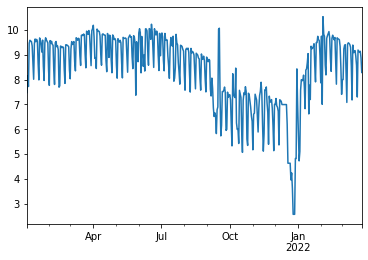

In [8]:
# gráfico do log dos casos diários
# se o log(dados) tiver o perfil de um modelo aditivo,
# então a série temporal original segue o modelo multiplicativo

np.log(df.loc[df['confirmed']>0]['confirmed']).plot()


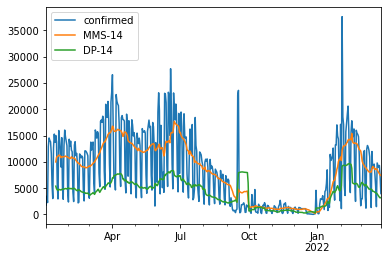

In [9]:
# verificando a média e desvio-padrão móvel com janela de 14 dias
# a forma de coleta dos dados de COVID são conhecidos por indicar coleta semanais
# a escolha pela janela de 14 dias foi feita para manter um múltiplo de 7 dias e ter curvas mais suaves para minimizar grandes flutuações

df['MMS-14'] = df['confirmed'].rolling(window=14).mean()
df['DP-14'] = df['confirmed'].rolling(window=14).std()

df[['confirmed','MMS-14','DP-14']].plot();

O gráfico do log(dados) mostra variações pico-vale próximas de um modelo aditivo, indicando que a série temporal segue um modelo multiplicativo.

A hipótese de modelo multiplicativo é fortalecido pelo gráfico lineplot da média movel e desvio-padrão em uma janela de 14 dias que mostram que ambos não são constantes ao longo do tempo, aumentando quando o valor absoluto da série temporal, no instante t, aumenta e diminuindo quando ela cai.

Com essas análises, fortalece-se a suposição inicial que o modelo multiplicativo é o mais adequado para supor a série temporal original

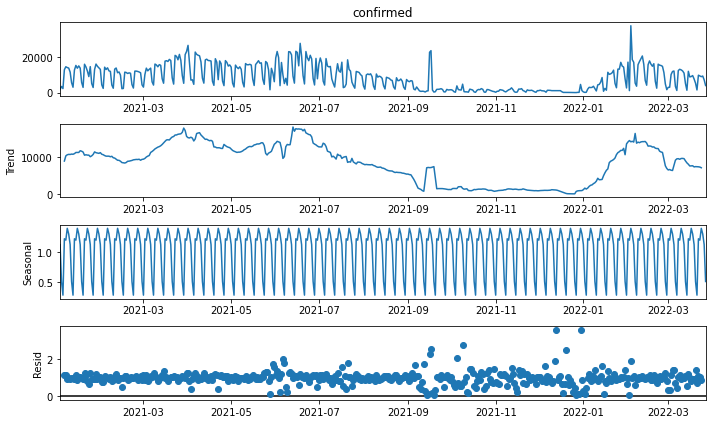

In [10]:
# decompondo a série com seasonal_decompose, segundo modelo multiplicativo

result = seasonal_decompose(df[df['confirmed']>0]['confirmed'], model='multiplicative')

rcParams['figure.figsize'] = 10, 6
fig = result.plot()
plt.show()


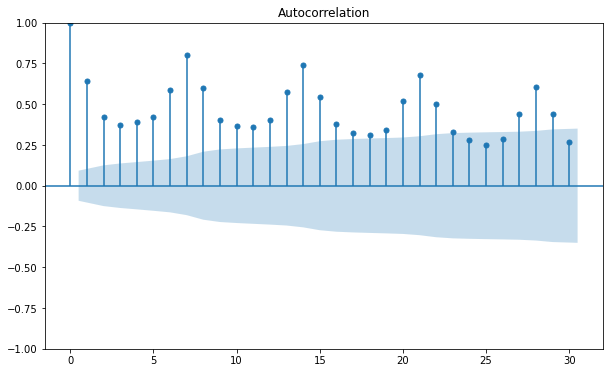

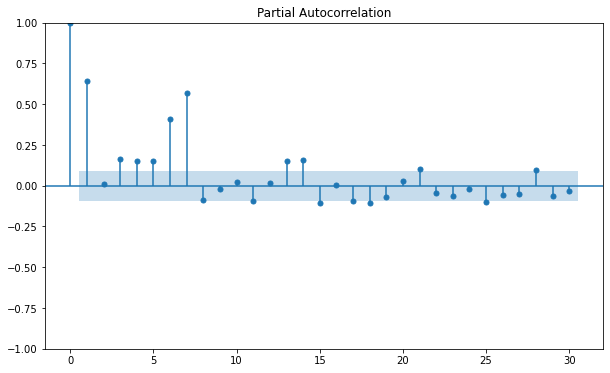

In [11]:
# gráficos de autocorrelação e autocorrelação parcial para identificar autocorrelação nos dados

plot_acf(df['confirmed'], lags=30)
plot_pacf(df['confirmed'], method='ywm', lags=30) 
plt.show()

**Resposta item 2**




Com o seasonal_decompose podemos avaliar os componentes da série temporal. Conseguimos enxergar a tendência subindo um pouco, atingindo os dois primeiros picos dos dados e depois recuando para valores menores após Setembro/2021 antes de ter um terceiro pico, já no ano de 2022.

O gráfico da sazonalidade mostra claramente os picos-vales sazonais constantes ao longo do tempo na série temporal decomposta pelo modelo multiplicativo.

Os resíduos ficam próximos de 1, com alguns pontos destoantes, que são momentos com grande variação nos dados. Como os resíduos ficam próximos e contantes de 1, na maior parte da série temporal, o modelo multiplicativo se mostra uma boa escolha para representar a série temporal.

Os gráficos de autocorrelação e autocorrelação parcial mostram que a série temporal apresenta uma autocorrelação de 7 dias, como já esperado de um banco de dados de casos diários de COVID-19 coletados no Brasil.

No gráfico de autocorrelação, os pontos do eixo X múltiplos de 7 (7, 14, 21, etc) serem os pontos mais elevados dentre os vizinhos e essa silhueta de queda mantendo os múltiplos de 7 altos indica essa autocorrelação de 7 dias nos dados.

Pelo formato de queda em 'ondas' (senóides) do gráfico de autocorrelação e o comportamento da autocorrelação parcial não ser semelhante de um modelo MA (que decai com senoides amortecidas), é uma boa hipótese imaginar que o modelo ARIMA(p,d,q) é o mais interessante para modelas os dados da série temporal.

## Item 3

3. Divida a série de registros confirmados em treinamento e teste, com 28 observações na base de teste. A que se referem os dados de treinamento e teste e como essa divisão contribui para a análise de modelos preditivos? 

In [12]:
# nr de dados do database para realizar a divisão para treino e teste
print('Quantidade de Observações: ' ,len(df))

#fazendo cópia do database para, depois, remover colunas que não serão utilizadas
df_copy = df.copy(deep=True)
df_copy = df_copy.drop(['week_number', 'year', 'MMS-14', 'DP-14'], axis = 1)

# dividindo em 422 observações para treino e 28 observ. teste
dado_treino = df_copy.iloc[:422]
dado_teste = df_copy.iloc[422:]


print('Quantidade de Observações na base de Treino: ' ,len(dado_treino))
print('Quantidade de Observações na base de Teste: ' ,len(dado_teste))


Quantidade de Observações:  450
Quantidade de Observações na base de Treino:  422
Quantidade de Observações na base de Teste:  28


**Resposta item 3**




A divisão do database em subconjuntos denominados de base de treino e de teste é utilizado para a geração de modelos preditivos.

A base de treino é o subconjunto de dados que irá induzir o modelo preditivo enquanto que a base de teste, como o nome diz, é o subconjunto de dados, desconhecido pelo modelo, que irá verificar a performance do modelo pela comparação da resposta gerada pelo modelo e o valor original da série temporal.

Dessa forma, dividindo o conjunto de dados em base de treino e teste, pode-se induzir diferente modelos e testá-los para identificar qual é o melhor para predizer a série temporal.

## Item 4


4. Utilizando a base de treinamento de registros confirmados de COVID-19, obtenha:

    - As previsões de Holt Winters.
    
    - As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido (auto_arima), para a variável confirmed. Identifique a natureza das componentes desse melhor modelo (por exemplo, “o modelo componentes autorregressiva não sazonal, componente de médias móveis sazonal", etc).
    
    - As previsões com o método Theta usual.
          
    - As previsões com um modelo de redes neurais recorrentes (LSTM ou GRU).    
    
    

In [13]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.forecasting.theta import ThetaModel



#### Holt-Winters

/Users/jp.ducatti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


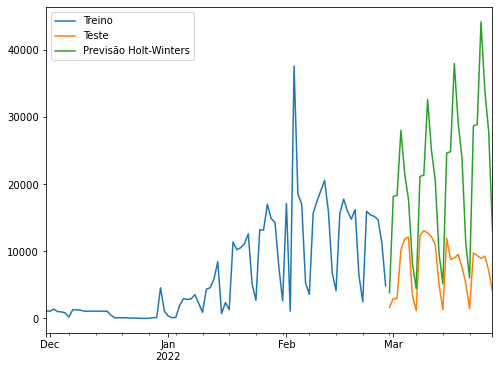

In [14]:
# suavização da série temporal utilizando Holt-Winters
# pelo método de Holt-winters, podemos designar separadamente se a tendenência e
# a sazonalidade serão aditiva ou multiplicativa. Pelas análises anterior,
# a tendência aparenta ser multiplicativa porque não é linear e a sazonalidade também aparenta ser
# aditiva porque apresenta variações na amplitude dos ciclos sazonais

ajuste_hw = ExponentialSmoothing(dado_treino['confirmed']
                                ,trend='multiplicative'
                                ,seasonal='multiplicative'
                                ,seasonal_periods=7).fit();

predito_hw = ajuste_hw.forecast(len(dado_teste)).rename('previsao_holt_winters') # 28 dados para teste
predito_hw.index = dado_teste.index

# plot da previsão com o modelo de suavização de Hot-Winters
dado_treino['confirmed'][-90:].plot(legend=True,label='Treino')
dado_teste['confirmed'].plot(legend=True,label='Teste',figsize=(8,6))
predito_hw.plot(legend=True,label='Previsão Holt-Winters');


#### SARIMA

In [15]:
# escolha do melhor SARIMA utilizando a biblioteca auto_arima 

auto_arima(df['confirmed'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  450
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -4315.335
Date:                             Wed, 07 Sep 2022   AIC                           8640.670
Time:                                     17:13:30   BIC                           8661.205
Sample:                                 01-02-2021   HQIC                          8648.765
                                      - 03-27-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6520      0.024    -27.254      0.000      -0.699      -0.605
ma.L2         -0.1782      0.026     -6.733      0.000      -0.230      -0.126
ar.S.L7        0.9739      0.014     67.545      0.000       0.946       1.002
ma.S.L7       -0.7515      0.034    -22.270      0.000      -0.818      -0.685
sigma2      1.281e+07   1.25e-09   1.03e+16      0.000    1.28e+07    1.28e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2871.75
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             1.23
Prob(H) (two-sided):                  0.01   Kurtosis:                        15.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.21e+30. Standard errors may be unstable.
"""

O melhor modelo SARIMA selecionado pela biblioteca auto_arima é o modelo SARIMA(0,1,2)x(1, 0,1)[7].

Esse modelo apresenta componentes não sazonais e sazonais (como esperado), sendo a sazonalidade de 7 dias.

**Dentre os componentes não sazonais, tem-se:**

- componente de MÉDIA MÓVEL de ordem 2:  indica que há uma dependência entre a observação Z(t) e os erros residuais de um modelo de média móvel aplicado a duas (2) observações em atraso;

- componente INTEGRADO de ordem 1: identifica a necessidade de aplicar uma diferença na série temporal original para torná-la ou estacionária ou com tendência de estacionariedade;

**Dentre os componentes sazonais, tem-se:**

- componente sazonal AUTOREGRESSIVO de ordem 1: identifica que a série temporal apresenta uma relação de dependência entre a observação corrente e a observação anterior do ciclo sazonal, que neste caso é o sétimo dado precedente. Portanto Z(t) tem dependência com a observação Z(t-7);

- componente sazonal MÉDIA MÓVEL de ordem 1: indica relação entre uma observação Z(t) com o erro residual de um modelo de média móvel aplicado a observação Z(t-7), que é a observação sazonal anterior;

- não há componente sazonal INTEGRADO: indica que não é necessário aplicar a diferença para a observação sazonal precedente. Apenas a componente não-sazonal INTEGRADO é suficiente para tornar a série ou estacionária ou com tendência de estacionariedade.

In [16]:
# indução do modelo
ajuste_sarima = SARIMAX(dado_treino['confirmed'],
                order=(0,1,2),seasonal_order=(1,0,1,7)).fit();


start=len(dado_treino)
end=len(dado_treino)+len(dado_teste)-1

predito_sarima = ajuste_sarima.predict(start=start,end=end,dynamic=False).rename('SARIMA(0,1,2)(1,0,1,7)')
predito_sarima.index = dado_teste.index   



/Users/jp.ducatti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85085D+00    |proj g|=  3.03178D-01

At iterate    5    f=  9.66993D+00    |proj g|=  1.95325D-02

At iterate   10    f=  9.66132D+00    |proj g|=  8.36268D-03

At iterate   15    f=  9.66073D+00    |proj g|=  7.60662D-04

At iterate   20    f=  9.66073D+00    |proj g|=  8.71704D-04

At iterate   25    f=  9.66058D+00    |proj g|=  1.10749D-02

At iterate   30    f=  9.64685D+00    |proj g|=  6.13127D-02

At iterate   35    f=  9.61440D+00    |proj g|=  4.67490D-03

At iterate   40    f=  9.60526D+00    |proj g|=  4.03545D-02

At iterate   45    f=  9.59821D+00    |proj g|=  1.93679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

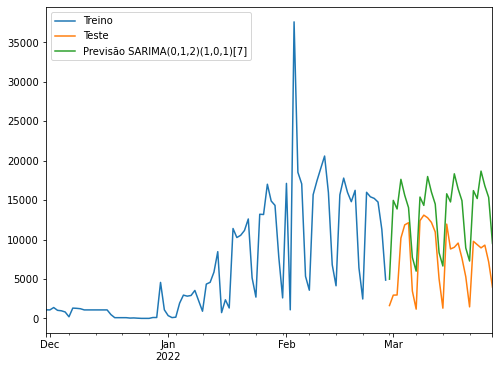

In [17]:
# plot da previsão com o modelo SARIMA(0,1,2)(1,0,1)[7]
dado_treino['confirmed'][-90:].plot(legend=True,label='Treino')
dado_teste['confirmed'].plot(legend=True,label='Teste',figsize=(8,6))
predito_sarima.plot(legend=True,label='Previsão SARIMA(0,1,2)(1,0,1)[7]');

#### Método Theta

In [18]:
ajuste_tm = ThetaModel(dado_treino['confirmed']).fit()
print(ajuste_tm.summary())

predito_tm = ajuste_tm.forecast(len(dado_teste)).rename('previsao_theta') # 28 dados para teste
predito_tm.index = dado_teste.index



                              ThetaModel Results                              
Dep. Variable:              confirmed   No. Observations:                  422
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Wed, 07 Sep 2022   Deseas. Method:         Multiplicative
Time:                        17:13:31   Period:                              7
Sample:                    01-02-2021                                         
                         - 02-27-2022                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0     -23.58938870107073
alpha 0.27921570156310527
-------------------------


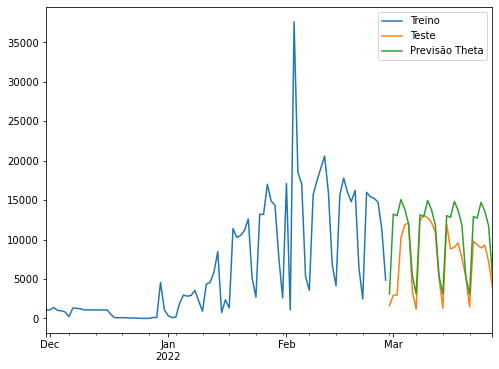

In [19]:
# plot da previsão com o Método Theta
dado_treino['confirmed'][-90:].plot(legend=True,label='Treino')
dado_teste['confirmed'].plot(legend=True,label='Teste',figsize=(8,6))
predito_tm.plot(legend=True,label='Previsão Theta');


#### Rede Neural Recorrente

In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

: 

: 

In [ ]:
# padronização dos dados para aplicar redeu neural
scaler = MinMaxScaler();
scaler.fit(dado_treino);

scaled_train = scaler.transform(dado_treino)
scaled_test = scaler.transform(dado_teste)



[[0.04651843]
 [0.09191978]
 [0.05944465]
 [0.34225225]
 [0.38621735]
 [0.37395606]
 [0.36653545]
 [0.307144  ]
 [0.14910368]
 [0.07971169]]


**Resposta Item 4**


## Item 5


5. Utilize o erro absoluto médio para comparar as previsões obtidas com as observações da base de teste. Qual o método que produz as melhores previsões? Represente em um mesmo gráfico a base de treinamento, de teste e as previsões obtidas pelos quatro métodos.


**Resposta Item 5**
